### Make necessary imports

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [11]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})

### We would like to select only those entries that have a sale price greater than 0

In [16]:
raw = raw[raw.SalePrice > 0]

### Now we select the sales with the proper PropertyType codes
The following are of interest to us:
 - 11: Household, single family units
 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [79]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]
df


,id,ExciseTaxNbr,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,footprint
2,0001000042,3018323,10/29/2019,485500,20191031001228,,,,,,...,0.0,0.0,2016.0,0.0,0.0,0.0,0.0,3.0,0.0,0.238254
8,0001000067,2979287,03/18/2019,358308,20190327000321,,,,,,...,0.0,1.0,1946.0,0.0,0.0,0.0,0.0,4.0,0.0,0.128736
11,0001200008,2991776,05/17/2019,850000,20190604001211,,,,,,...,0.0,1.0,1964.0,0.0,0.0,0.0,0.0,4.0,0.0,0.072488
22,0002000015,3022128,11/19/2019,465000,20191122001296,,,,,,...,0.0,1.0,1961.0,0.0,0.0,0.0,0.0,5.0,0.0,0.086336
36,0003000086,2995868,06/18/2019,350000,,,,,,,...,0.0,0.0,1948.0,0.0,0.0,0.0,0.0,4.0,0.0,0.081522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62024,9842300625,3014225,09/25/2019,620000,20191008000541,,,,,,...,0.0,0.0,1951.0,0.0,0.0,0.0,0.0,3.0,0.0,0.245623
62025,9842300690,3001023,07/22/2019,849950,20190724000917,,,,,,...,0.0,0.0,2016.0,0.0,0.0,0.0,0.0,3.0,0.0,0.224150
62030,9888200010,3026407,12/17/2019,510000,20191219001447,,,,,,...,0.0,0.0,2008.0,0.0,0.0,0.0,0.0,4.0,0.0,0.184978
62035,9900000470,2993626,06/06/2019,1275000,20190614000593,,,,,,...,0.0,0.0,2018.0,0.0,0.0,0.0,0.0,3.0,0.0,0.234552


In [71]:
raw[raw.PropertyType == 14].SalePrice.describe()

count    2.217000e+03
mean     4.537666e+05
std      2.872387e+05
min      5.100000e+04
25%      2.800000e+05
50%      3.800000e+05
75%      5.500000e+05
max      4.500000e+06
Name: SalePrice, dtype: float64

### Generate our first simple model of Sale Price vs Sqft of Living Space

In [72]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
fsm = ols(formula=formula, data=fsm_df).fit()

Let's see that big table

In [73]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:10:03   Log-Likelihood:            -2.7203e+05
No. Observations:               18807   AIC:                         5.441e+05
Df Residuals:                   18805   BIC:                         5.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.591e+04   8189.002     -1.942      0.052    -3.2e+04     144.477
SqFtTotLiving   378.6638      3.476    108.935      0.000     371.850     385.477
==============================================================================
Omnibus:                    24151.837   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12404873.130
Skew:                           6.729   Prob(JB):                         0.00
Kurtosis:                     128.096   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Not bad, let's check homoscedasticity**

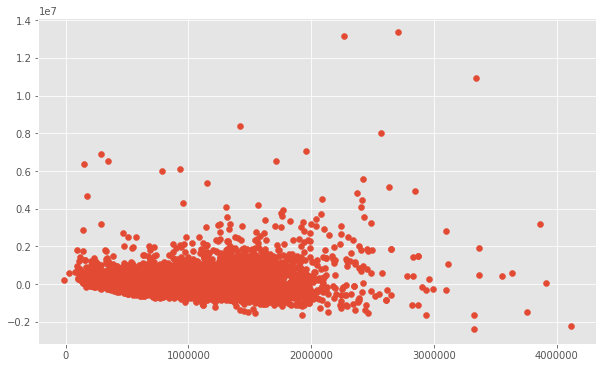

In [74]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

 - from this picture it apppears that our model is a worse predictor as homes go above 1 million dollars
 
**Let's check normality**

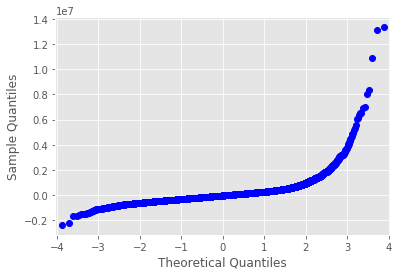

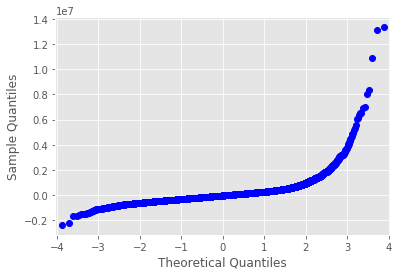

In [75]:
sm.qqplot(fsm_resids)

 - The eyeball test here is to look for a straight line, which it clearly is not!
 - This is supported by the JB p-value in the above summary table, which tells us that this is not normally distributed

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3] in either the sale price or the square foot columns

In [91]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [92]:
formula = 'SalePrice ~ SqFtTotLiving'
ssm = ols(formula=formula, data=ssm_df).fit()

In [93]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Tue, 16 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:28:20   Log-Likelihood:            -2.5776e+05
No. Observations:               18360   AIC:                         5.155e+05
Df Residuals:                   18358   BIC:                         5.155e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.587e+05   5933.069     26.755      0.000    1.47e+05     1.7e+05
SqFtTotLiving   279.5570      2.646    105.664      0.000     274.371     284.743
==============================================================================
Omnibus:                     3717.266   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9797.794
Skew:                           1.097   Prob(JB):                         0.00
Kurtosis:                       5.827   Cond. No.                     5.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### looks like we have a very different coefficient, but no improvement in the coefficient

ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

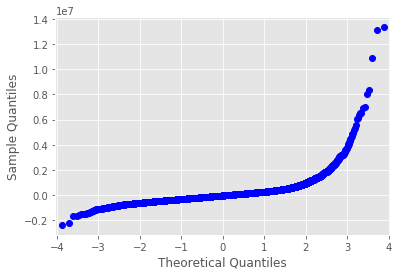

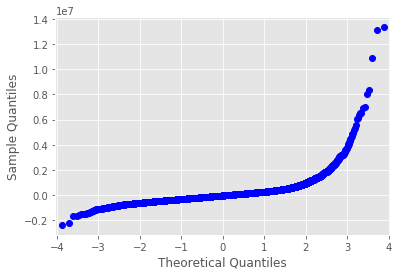

In [95]:
sm.qqplot(fsm_resids)